# Investigating Forecasting Short Term Copper Demand

The below is an illustration of some of the thoughts and processes around trying to forecast demand for copper, including an explanation of decision making, detailing of data diagnostics & preparation, pre-processing and modelling, before finally evaluating.

When actually forecasting demand for use in a business context there may well be additional steps taken depending on time constraints and/or required accuracy. These will also be highlighted along the way..

---

## Task

Having an up-to-date, timely indicator of copper demand can be particularly useful for decision making/risk management purposes.

Though there are no universally accepted copper demand series, commodity consultant Wood Mackenzie’s (WM) refined copper demand numbers are well-respected. Updates are dependent upon the release of their reports and it’s not always clear how quickly the latest updates are factored in to their own forecasts, how those forecasts have evolved, as well as how the forecasts themselves have been implemented.

Demand forecasts can be generated from historical demand data and optionally supplemented with exogenous variables. Updates to these variables can be used to supplement overall demand expectations where they occur prior to the release of demand data.

This project has the potential to be extremely large in complexity, with more tests, parameter tuning and variable additions. To avoid getting overly bogged down in every single detail, there won't be a comment for each line of code, decision inclusion/exclusion etc. The below should serve as a great illustration of how the task might be approached.

---

## Defining Underlying Demand

The WM data we have is yearly (providing data from 1976-2040). We do however have a public monthly indicator for copper demand from the ICSG (data from Aug 2004 to April 2019) which is available through Wind. ICSG data is also split into 10 countries/regions on a monthly basis as well, which would be useful for more granular analyses. ICSG public data has a delay of around three months.

Seasonality of ICSG can therefore be applied to WM data. We could just use ICSG data directly of course, but WM tends to be more widely recognised. In a more detailed project, we might investigate differences in WM and ICSG demand accounting as well, such as how each factor in bonded warehouse stock changes.

We could either apply overall seasonal trends to each year or apply the percentage contribution of each month to each year. The former would likely lose too much granularity, although with the latter the limitation is that the monthly weights could highlight inaccuracies or differences in methodologies. Either way, the result would be far better than any blind interpolation and in this case we've chosen the latter.

Typically we'd use packages we've created to import data directly from vendor APIs or local/remote databases, but for ease we've packaged data we've loaded the data into a csv for reference.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy
import pandas as pd
import datetime as dt
import numpy as np

In [2]:
raw_data = pd.read_csv('data/demand.csv', index_col='Dates', parse_dates=True)

We'll separate out the Yearly WM data and the Monthly ICSG data from the DataFrame and apply the seasonal trends of the latter to the former to create a monthly WM series.

As we know ICSG monthly data doesnt go back as far, we'll use the start date from that series. For training and testing we’ll use data up to 2018 under the assumption that they include no or few forecast elements and the demand values are less likely to change meaningfully and are representative of actual demand.

In [3]:
start_date = raw_data['ICSG M'].dropna().first_valid_index() # Jan-15
end_date = dt.datetime(2018, 12, 31)
global_demand = raw_data[['WM Y', 'ICSG M']][start_date:end_date]
global_demand['ICSG M%'] = global_demand['ICSG M'] / global_demand['ICSG M'].resample('Y').sum().resample('M').last().reindex(pd.date_range(start_date, end_date)).bfill()
global_demand['WM M'] = global_demand['WM Y'].bfill() * global_demand['ICSG M%']
global_demand.index.freq = 'M'

In [4]:
global_demand.head()

,WM Y,ICSG M,ICSG M%,WM M
Dates,,,,
2005-01-31,NaN,1400.0,0.085039,1428.789759
2005-02-28,NaN,1252.0,0.076049,1277.746270
2005-03-31,NaN,1397.0,0.084857,1425.728067
2005-04-30,NaN,1361.0,0.082670,1388.987758
2005-05-31,NaN,1414.0,0.085890,1443.077656


---

## Diagnostics

Now we have a monthly global demand series from WM. Lets run some diagnostic tests to understand the structure of the data a little better.

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [6]:
sd_result = seasonal_decompose(global_demand['WM M'], model='add')

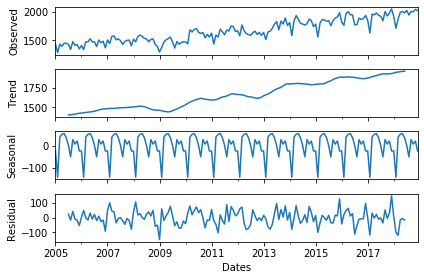

In [7]:
sd_result.plot();

It's clear this data is not stationary, so no need to test if the data is stationary at this stage (as it clearly isn't). Clear trend and seasonality elements to the historical series. Lets plot out a quick seasonal chart of the last few years for clarity..

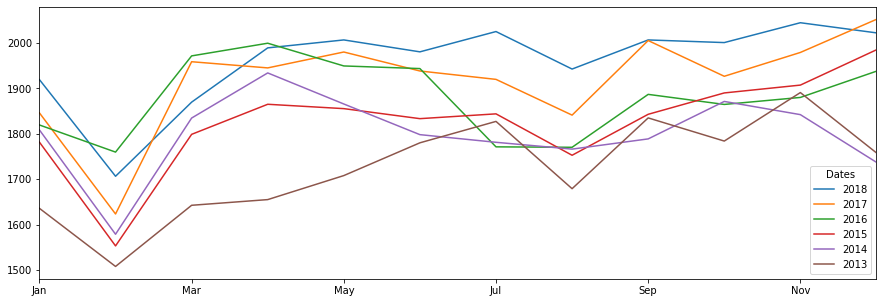

In [8]:
raw_seas_data = global_demand[['WM M']]['20130101':].reset_index(level=0)
formatted_seas_data = raw_seas_data.set_index([raw_seas_data['Dates'].dt.month, raw_seas_data['Dates'].dt.year])['WM M'].unstack()
formatted_seas_data = formatted_seas_data.iloc[:, ::-1]
formatted_seas_data.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
formatted_seas_data.plot(figsize=(15,5))

Here we can clearly see the seasonal element of the data. 2014-2018 have a particularly tight pattern.

---

## Forecasting (Univariate)

### Methods using historical demand data & dates without additional fundamental / macro variables

Lets assess how a collection of appropriate forecasting methods work directly for assessing 2018 demand data training on data from previous years.

It's worth bearing in mind that demand is constantly evolving and these predictions outside of training sets will naturally always be limited by this. That's not to say that these forecasts can't still be improved by adding other variables - either those that are known eg holidays or those that update with a lesser lag eg certain economic data.

On a larger project we'd take things one stage further and produce a stepwise (walk-forward) model to assess how forecasts adjust on an iterative basis. This takes considerably more time (given models are run with every data update), but allows a fuller assessment of model performance over time. For the purposes of this notebook we'll stick with the standard train/test splits for investigation.

#### SARIMA

Given the highly seasonal nature of the data, SARIMA would be a worthy starting point.

First we need to get the ideal p, d, q (and seasonal p, d, q) orders from a grid search. We might do this by running through different combinations and analysing ACF and PACF plots of order combinations with better AIC values, but good results can also be acheived from the Pyriamid Arima package (which does exactly that on an automated basis), which we'll use in this case. Note, there are times where this grid search does fall short, so there still needs to be some oversight. Exanding to use a combination of AIC, BIC and HQIC may work better as there are times where AIC is low, but the others are higher.

In [9]:
from pmdarima import auto_arima

In [10]:
sarima_train = global_demand['WM M'][:'20171231']
sarima_test = global_demand['WM M']['20180101':]

In [11]:
auto_arima(sarima_train, seasonal=True, m=12, suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -863.232
Date:                            Mon, 23 Sep 2019   AIC                           1736.463
Time:                                    10:09:38   BIC                           1751.680
Sample:                                         0   HQIC                          1742.644
                                            - 156                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1532      0.472      0.325      0.745      -0.771       1.077
ma.L1         -0.5258      0.072     -7.263      0.000      -0.668      -0.384
ar.S.L12       0.9600      0.035     27.524      0.000       0.892       1.028
ma.S.L12      -0.6865      0.100     -6.879      0.000      -0.882      -0.491
sigma2      3715.6060    372.651      9.971      0.000    2985.223    4445.989
===================================================================================
Ljung-Box (Q):                       55.02   Jarque-Bera (JB):                 6.73
Prob(Q):                              0.06   Prob(JB):                         0.03
Heteroskedasticity (H):               2.07   Skew:                            -0.25
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
sarimax_model = SARIMAX(sarima_train, order=(0,1,1), seasonal_order=(1,0,1,12))

In [14]:
sarima_results = sarimax_model.fit()
start = len(sarima_train)
end = len(sarima_test) + len(sarima_train) - 1
sarima_pred = sarima_results.predict(start, end, typ='levels').rename('sarima_predictions')

We've now run the SARIMA predictions using levels generated by our grid search and we can now evaluate the results. For this we'll use the root mean square error (also denominated by the mean for ref) and well as a quick visual plot.

In [15]:
from statsmodels.tools.eval_measures import rmse

In [16]:
rmse(sarima_test, sarima_pred), rmse(sarima_test, sarima_pred) / sarima_test.mean()

(73.41260589690917, 0.037466334806768455)

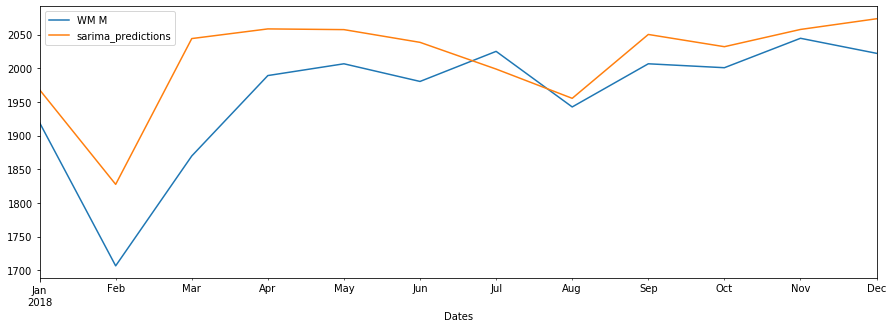

In [17]:
sarima_test.plot(legend=True, figsize=(15,5))
sarima_pred.plot(legend=True)

Not bad, but definite room for improvement. It's not uncommon for S&D balances to touch 73Kt so we'd certainly look to further optimise.

The model as a whole tended to overpredict - adding exogenous variables through a SARIMAX model would be worth investigating as a step to forecast improvement.

#### XGBoost

We can also investigate decision tree models as an option for forecast comparison. XGBoost has a regression algorithm we can use for use with time series.

There's no innate seasonality adjustment, but we can include a month and year column as as extra features in order to feed in these details.

In [18]:
import xgboost as xgb

In [19]:
global_demand['Month'] = global_demand.index.month
global_demand['Quarter'] = global_demand.index.quarter
global_demand['Year'] = global_demand.index.year
# Lots more possibilities to consider along the same lines, such as:
# global_demand['MonthDay'] = global_demand.index.day
# global_demand['YearDay'] = global_demand.index.dayofyear

In [20]:
xgb_xtrain = global_demand[global_demand.columns[4:]][:'20171231']
xgb_ytrain = global_demand[['WM M']][:'20171231']
xgb_xtest = global_demand[global_demand.columns[4:]]['20180101':]
xgb_ytest = global_demand[['WM M']]['20180101':]

In [21]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(xgb_xtrain, xgb_ytrain, verbose=False)

[10:09:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [22]:
xgb_pred = pd.Series(xgb_model.predict(xgb_xtest), xgb_ytest.index).rename('xgb_predictions')

In [23]:
rmse(xgb_ytest['WM M'], xgb_pred), rmse(xgb_ytest['WM M'], xgb_pred) / xgb_ytest['WM M'].mean()

(66.71310382888373, 0.034047224635529505)

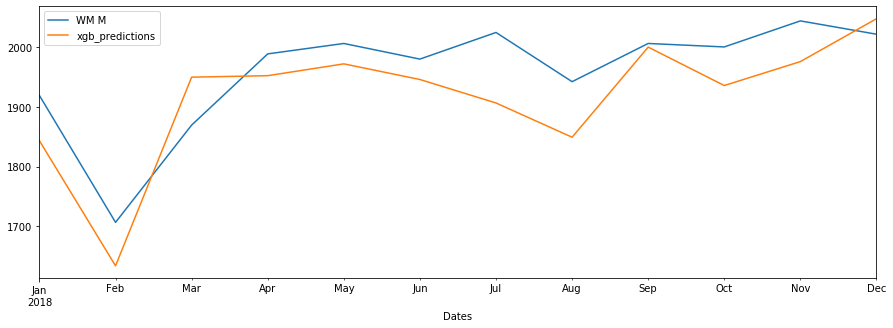

In [24]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
xgb_pred.plot(legend=True)

Interesting with the XGBoost results are that the errors are similar, but predictions have tended to underestimate on this occasion.

To improve we might look to see how much each variable added to the prediction and remove those that weren't influential.

As with SARIMA, exogenous variables would be the step after, perhaps also considering lagged indicators and/or holidays from major consuming nations.

#### LSTM

Long-short term memory is a recurrent neural network which can be applied to time series' in order to make forecasts. 

There's some additional pre-processing required to be as effective as possible, so we'll first scale the data then pass through Keras' time series generator to produce training batches.

In [25]:
# seed data for LSTM forecasts
from numpy.random import seed
seed(8)
from tensorflow import set_random_seed
set_random_seed(8)

In [26]:
lstm_train = global_demand['WM M'][:'20171231']
lstm_test = global_demand['WM M']['20180101':]

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(lstm_train.values.reshape(-1, 1))
scaled_train = scaler.transform(lstm_train.values.reshape(-1, 1))

In [28]:
from keras.preprocessing.sequence import TimeseriesGenerator
length = 12
batch = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length, batch_size=batch)

Using TensorFlow backend.


In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [30]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, batch)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=200, verbose=0)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [31]:
test_predictions = []
first_batch = scaled_train[-length:]
current_batch = first_batch.reshape((1, length, batch))
for b in range(len(lstm_test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [32]:
lstm_pred = pd.Series(scaler.inverse_transform(test_predictions).reshape(1,12)[0], lstm_test.index).rename('lstm_predictions')

In [33]:
rmse(lstm_test, lstm_pred), rmse(lstm_test, lstm_pred) / lstm_test.mean()

(92.75242025973002, 0.04733646475469205)

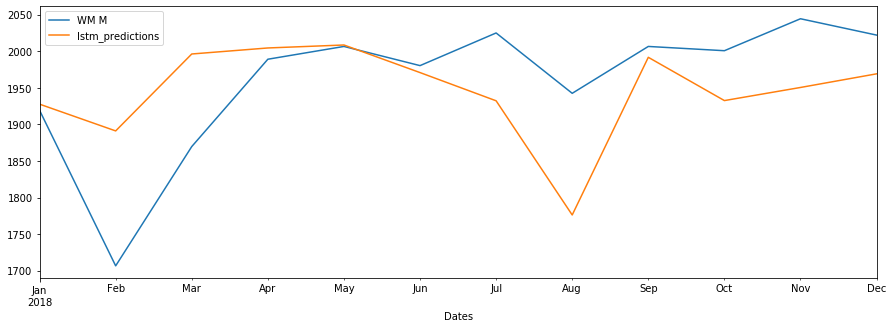

In [34]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
lstm_pred.plot(legend=True)

One point to note here is that running the above again will yeild slightly different results given neural networks use randomness by design. In a context where more stable results are required we can either seed the random number generator with a specified integer, or run the analysis multiple times and take the average. The latter is considered better, but typically takes much more time than the other methods here.

We've run the analysis a number of times (outisde this notebook) and LSTM was in the range of the other models +/- 20Kt, although just one run does take considerably longer to process. We could look into adjusting the number of neurons or epochs to speed up, looking into where the marinal gain from each is negligible to avoid unecessary processing.

We could look at different LSTM options (such as a stacked model) or other neural network options such as a Multilayer Perceptron (MLP) architechture for example. As with other time series analysis, conducting multivariate analysis with appropriate exogenous variables would also be worth exploring.

For reference lets plot all the predictions together:

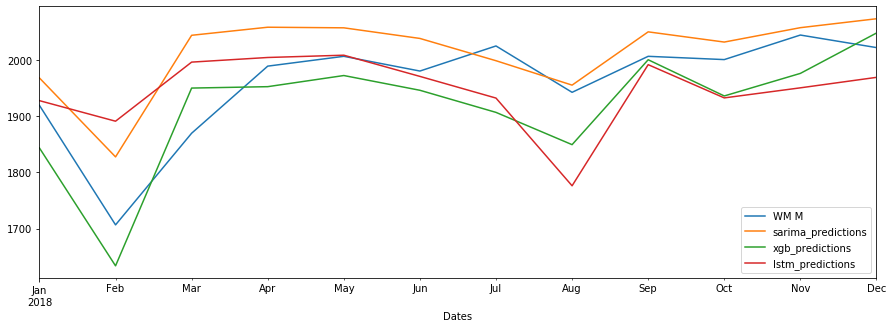

In [35]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
sarima_pred.plot(legend=True)
xgb_pred.plot(legend=True)
lstm_pred.plot(legend=True)

The plots themselves highlight the potential usefulness of stacking different time series options, either through averaging or regression. From the above, we can see an average of SARIMA and XGBoost might be of interest for example:

In [36]:
sarima_xgb_pred = (sarima_pred + xgb_pred) / 2
rmse(xgb_ytest['WM M'], sarima_xgb_pred), rmse(xgb_ytest['WM M'], sarima_xgb_pred) / xgb_ytest['WM M'].mean()

(47.582567015683956, 0.024283900087657424)

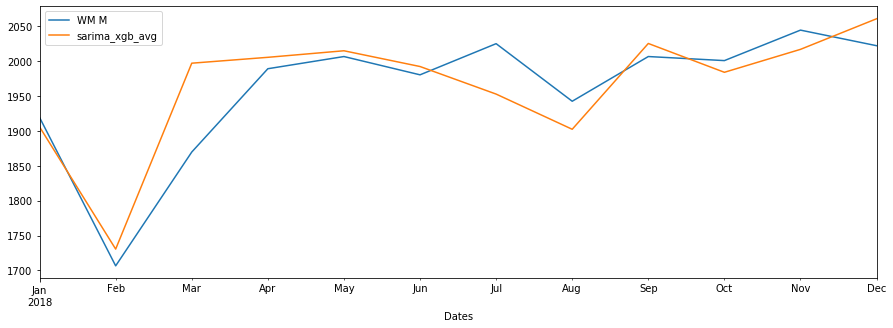

In [37]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
sarima_xgb_pred.rename('sarima_xgb_avg').plot(legend=True)

The above looks like the best solution thus far, although of course this isn't a reflection of performance over time. We'll expand on this later.

There are of course a number of other options for forecasting, including other related options, such as different decision tree algorithms etc, as well as options like Facebook's Prophet (or Google's Causal Impact or Uber's Edward).

---

### Identifying areas for useful additional variables

#### Fundamental
There are a number of fundamental demand layers we can highlight and data from these areas could serve to improve our analysis:

- First Use Production (% global demand)
    - Wire Rod (74%)
    - Billet (13%)
    - Cake/Slab (13%)
- End Use Production
    - Real Estate/Construction (28%)
    - Electrical Network (28%)
    - White Goods/Consumer (21%)
    - Transport/Autos (12%)
    - Machinery (11%)
- Macroeconomic
    - Industrial Production
    - PMI Surveys

#### Historical holidays
February tends to be notably lower than other months on a seasonal basis. Part of this is due to the fact that China's Spring Festival (Chinese New Year) tends to fall in February and that China are responsible for around half of global copper consumption. It can however occur in January or be spread over January and February. Including the number of Chinese holidays per month might also be a good series to investigate in order to try and capture impact in Q1 particularly.

---

## Multivariate Analysis

One point of note is that global variables tend to either not exist, or be particularly delayed, so typically with these additional variables, we'll have to break down demand and focus on major consuming countries and their respective fundamental data series. This is also true of holidays. Splitting out regionally should improve variable impact through more a more accurate causal link with specifically regional variables.

In order that the notebook doesn't get overly long, we'll first take a look at a global IP variable before splitting out China data to see if we can improve forecasts for China specifically.

Given in our initial analysis LSTM took far longer to calculate (which will be exacerbated with multiple variables) and the predictions were no better than other methods, we'll focus the multivariate analysis on SARIMAX and XGBoost for the remainder, but refer back to other options in the conclusion.

### Global IP

One measure of global IP with a good history and a minimal relative delay is that from CPB Netherlands. At the time of writing the date range is Jan 2000 to Jun 2019. The series is published seasonally adjusted, but not trend adjusted, so we'll take the first difference, plot a histogram and check the p-value to make the data stationary and effectively use the MoM change for predictive impact. Lets bring in the data set and format.

In [38]:
ip = pd.read_csv('data/CPB_IP.csv', index_col='Dates', parse_dates=True)
ip.index.freq = 'M'
ip['global_ip_diff'] = ip['global_ip'].diff()

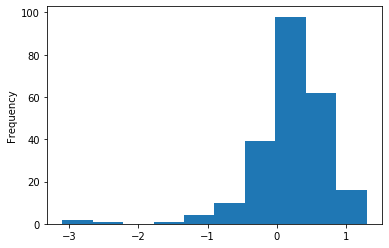

In [39]:
ip['global_ip_diff'].plot.hist()

In [40]:
# p-value check
from statsmodels.tsa.stattools import adfuller
adfuller(ip['global_ip_diff'].dropna(),autolag='AIC')[1]

9.643268586518403e-08

For the forcast models above we've put them into functions to avoid repeating steps and making things a little cleaner.

In [41]:
import forecasts

#### SARIMAX

In [42]:
exog_train = ip[['global_ip_diff']]['20050101':'20171231']
exog_test = ip[['global_ip_diff']]['20180101':'20181231']
auto_arima(sarima_train, exogenous=exog_train, seasonal=True, m=12, suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -862.730
Date:                            Mon, 23 Sep 2019   AIC                           1737.459
Time:                                    10:27:38   BIC                           1755.720
Sample:                                         0   HQIC                          1744.876
                                            - 156                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1498      0.455      0.329      0.742      -0.742       1.041
x1             8.9076      9.930      0.897      0.370     -10.555      28.370
ma.L1         -0.5336      0.073     -7.337      0.000      -0.676      -0.391
ar.S.L12       0.9608      0.034     28.061      0.000       0.894       1.028
ma.S.L12      -0.6907      0.098     -7.016      0.000      -0.884      -0.498
sigma2      3689.4756    365.925     10.083      0.000    2972.275    4406.676
===================================================================================
Ljung-Box (Q):                       54.74   Jarque-Bera (JB):                 6.44
Prob(Q):                              0.06   Prob(JB):                         0.04
Heteroskedasticity (H):               2.23   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
sarimax_ip_results = forecasts.sarimax_fc(sarima_train, sarima_test, (0,1,1), (1,0,1,12), exog_train=exog_train, exog_test=exog_test)

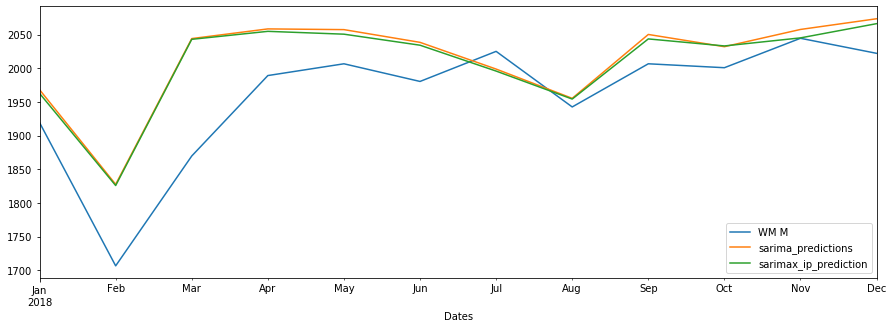

In [44]:
sarima_test.plot(legend=True, figsize=(15,5))
sarima_pred.plot(legend=True)
sarimax_ip_results['prediction'].rename('sarimax_ip_prediction').plot(legend=True)

In [45]:
sarimax_ip_results['rmse'], sarimax_ip_results['rmse_pct']

(71.04737740153399, 0.036259233633617396)

An improvement, albeit not a game changer. If we were to stay with global variables we might also try a global PMI instead of or in addition to. Markit do one, but for the full history there's an additional subscription.

#### XGBoost

In [46]:
xgb_xtrain_ip = xgb_xtrain.join(exog_train)
xgb_xtest_ip = xgb_xtest.join(exog_test)

In [47]:
xgb_ip_results = forecasts.xgb_fc(xgb_xtrain_ip, xgb_xtest_ip, xgb_ytrain, xgb_ytest)
xgb_ip_results['rmse'], xgb_ip_results['rmse_pct']

[10:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(70.34931025008447, 0.03590297305283183)

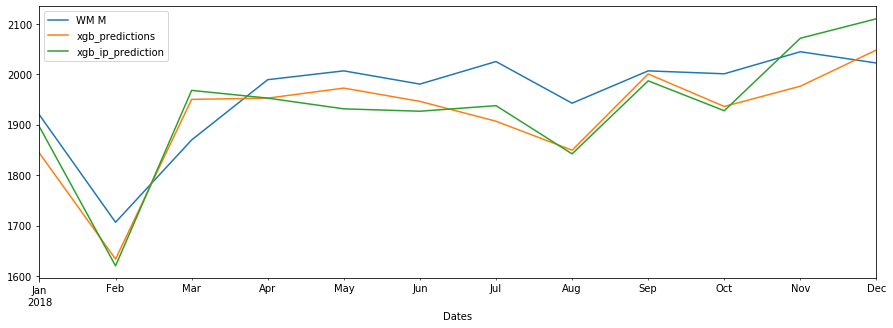

In [48]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
xgb_pred.plot(legend=True)
xgb_ip_results['prediction'].rename('xgb_ip_prediction').plot(legend=True)

Adding IP to our XGBoost forecasts actually resulted in a weaker forecast (from an rmse perspective), though there wasn't really much change and some months did see a prediction improvement.

### Regional Split

Another method we might use in order to improve predictions is to break the forecast problem down regionally. Rather than use global variables to predict a global demand number, we can split out the most important regions and use data specific to that region to improve.

Splitting regionally in itself should theoretically improve the performace (even without additional variables) given different regions may exhibit different trend and seasonality which may be eaiser to predict without the additional noise of the others combined. The ability to then add specifics not possible (or not as useful) under a combined model, such as regional holidays or region-specific variables opens up further avenues to explore improvements.

To illustrate, we'll look at breaking out Chinese consumption (given China is the largest copper consumer) and then perform two separate forecasts.

#### China

We have consumption data from WM and the ICSG like we did with the total consumption numbers, although the ICSG data for China (as for the rest of the regional breakdowns) starts in Aug 2012. This reduces our training set significantly to the point where we'd have 5 years of training data to one year of test data. The ICSG does have additional history over that which is available on Wind, but at this time we don't have access to that data so in this case we'll use the limited history to see whether it's sufficient to improve our 2018 prediction.

Lets split out our data, run our separate forecasts, combine and assess.

In [49]:
# from earlier..
global_demand.head()

,WM Y,ICSG M,ICSG M%,WM M,Month,Quarter,Year
Dates,,,,,,,
2005-01-31,NaN,1400.0,0.085039,1428.789759,1,1,2005
2005-02-28,NaN,1252.0,0.076049,1277.746270,2,1,2005
2005-03-31,NaN,1397.0,0.084857,1425.728067,3,1,2005
2005-04-30,NaN,1361.0,0.082670,1388.987758,4,2,2005
2005-05-31,NaN,1414.0,0.085890,1443.077656,5,2,2005


In [50]:
# recreated for China
start_date = dt.datetime(2013, 1, 1)
china_demand = raw_data[['WM Y CH', 'ICSG CH']][start_date:end_date]
china_demand['ICSG M% CH'] = china_demand['ICSG CH'] / china_demand['ICSG CH'].resample('Y').sum().resample('M').last().reindex(pd.date_range(start_date, end_date)).bfill()
china_demand['WM M CH'] = china_demand['WM Y CH'].bfill() * china_demand['ICSG M% CH']
china_demand.index.freq = 'M'
china_demand.head()

,WM Y CH,ICSG CH,ICSG M% CH,WM M CH
Dates,,,,
2013-01-31,NaN,738.7,0.075583,700.734419
2013-02-28,NaN,646.8,0.066180,613.557632
2013-03-31,NaN,672.6,0.068820,638.031637
2013-04-30,NaN,737.7,0.075481,699.785814
2013-05-31,NaN,816.8,0.083575,774.820460


In [51]:
multi_demand = global_demand[['WM M']].join(china_demand[['WM M CH']], how='right')
multi_demand['WM M EXCH'] = multi_demand['WM M'] - multi_demand['WM M CH']

Lets asses how the split (and the lower sample size) impacts our forecasts from before..

#### SARIMA

In [52]:
sarima_multi_train = multi_demand['20120101':'20171231']
sarima_multi_test = multi_demand['20180101':'20181231']

In [53]:
# rerun arima grid search on new data and retreive predictions/evaluations
aa_ch_results = auto_arima(sarima_multi_train['WM M CH'], seasonal=True, m=12, suppress_warnings=True)
aa_ch_order, aa_ch_seasonal_order = aa_ch_results.order, aa_ch_results.seasonal_order
sarima_ch_results = forecasts.sarimax_fc(sarima_multi_train['WM M CH'], sarima_multi_test['WM M CH'], aa_ch_order, aa_ch_seasonal_order)

c:\users\rimi\pycharmprojects\jupyter_test\venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [54]:
aa_exch_results = auto_arima(sarima_multi_train['WM M EXCH'], seasonal=True, m=12, suppress_warnings=True)
aa_exch_order, aa_exch_seasonal_order = aa_exch_results.order, aa_exch_results.seasonal_order
sarima_exch_results = forecasts.sarimax_fc(sarima_multi_train['WM M EXCH'], sarima_multi_test['WM M EXCH'], (0,1,1), (0,1,1,12))

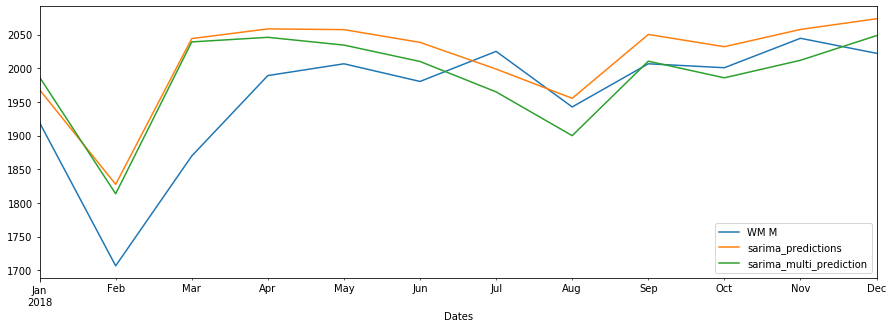

In [55]:
# check how the combined prediction holds up
sarima_multi_prediction = sarima_ch_results['prediction'] + sarima_exch_results['prediction']
sarima_test.plot(legend=True, figsize=(15,5))
sarima_pred.plot(legend=True)
sarima_multi_prediction.rename('sarima_multi_prediction').plot(legend=True)

In [56]:
rmse(sarima_test, sarima_multi_prediction), rmse(sarima_test, sarima_multi_prediction) / sarima_test.mean()

(68.90877358775816, 0.035167791019273004)

Despite the small sample size (notwithstanding this is just one test) this new prediction (green line) did slightly improve our initial prediction on the global demand series (yellow line). Q1 is still the main issue, but it appears as if the smaller sample size hasn't impacted overall at this stage.

To keep things together we'll look at improving SARIMA forecasts with additional variables before checking out XGBoost. First we'll introduce China holidays (or business days) then some favourite end-use demand indicators.

We looked through a few holiday packages on Python, but they were either wrong, they didn't got back far enough or they didn't have China. In the end we just created our own csv with just a list of holiday dates to import and process.

In [57]:
holidays = pd.read_csv('data/china_calendar.csv', index_col='Dates', parse_dates=True)
holidays['china_holidays'] = 1
china_days = holidays.groupby(pd.Grouper(freq='M')).sum()

In [58]:
china_days.head()

,china_holidays
Dates,
2005-01-31,1
2005-02-28,5
2005-03-31,0
2005-04-30,0
2005-05-31,5


We could simply process this number as an exogenous variable, but what we're really looking for is business days in the for each month given that's more aligned with the demand metric sought. So lets calculate that..

In [59]:
from pandas.tseries.offsets import BDay
china_weekdays = pd.date_range('20050101', '20201231', freq=BDay())
china_weekdays_monthly = pd.DataFrame([1]*len(china_weekdays), china_weekdays, ['china_weekdays']).groupby(pd.Grouper(freq='M')).sum()
china_days = china_days.join(china_weekdays_monthly, how='outer').fillna(0)
china_days['china_workdays'] = china_days['china_weekdays'] - china_days['china_holidays'] 

In [60]:
ch_hols_train = china_days[['china_workdays']]['20130101':'20171231']
ch_hols_test = china_days[['china_workdays']]['20180101':'20181231']

In [61]:
aa_ch_hols = auto_arima(sarima_multi_train['WM M CH'], exogenous=ch_hols_train, seasonal=True, m=12, suppress_warnings=True)
aa_ch_hols_order, aa_ch_hols_seasonal_order = aa_ch_hols.order, aa_ch_hols.seasonal_order

In [62]:
sarima_chhol_results = forecasts.sarimax_fc(sarima_multi_train['WM M CH'], sarima_multi_test['WM M CH'], aa_ch_hols_order, aa_ch_hols_seasonal_order, exog_train=ch_hols_train, exog_test=ch_hols_test)

In [63]:
sarima_chhol_results['rmse'], sarima_chhol_results['rmse_pct']

(73.24467055425579, 0.07450504760965243)

In this occasion, the addition of holidays actually reduced the total accuracy for 2018 predictions. Lets look at using auto production. Why not grid investment, property sales/starts? These are of course valid contributors to copper demand, but the adjusting this data requires an additional in-depth analysis/discussion. Overall, a better way to approach this might be to to build a copper demand index weighted by general demand contributions to capture the relative importance of these variables, but we'll leave that for another notebook..

In [64]:
end_use = pd.read_csv('data/end_use_demand.csv', index_col='Dates', parse_dates=True)
end_use.index.freq = 'M'

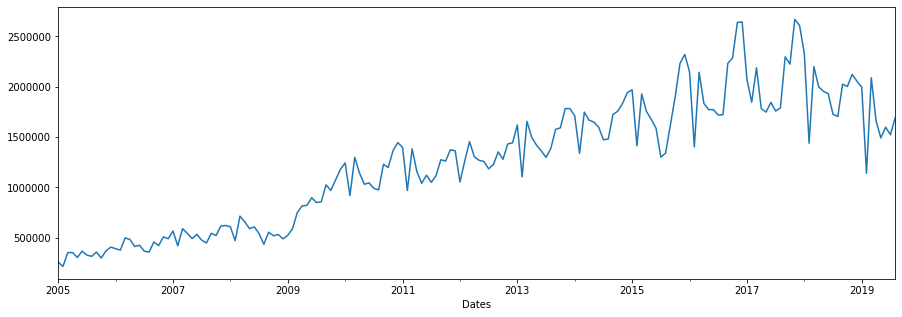

In [65]:
end_use['auto_production'].plot(figsize=(15,5))

As with IP, we're looking at the impact from auto production outside of standard seasonality, so lets seasonally adjust (with statsmodels in this case) and difference as with IP, before plotting all the predictions together.

In [66]:
sd_result_auto = seasonal_decompose(end_use['auto_production'], model='mul')
end_use_sa = (sd_result_auto.observed - sd_result_auto.seasonal).dropna().diff().to_frame('auto_prod_sa')
auto_train = end_use_sa['20130101':'20171231']
auto_test = end_use_sa['20180101':'20181231']

In [67]:
aa_ch_ip = auto_arima(sarima_multi_train['WM M CH'], exogenous=auto_train, seasonal=True, m=12, suppress_warnings=True)
aa_ch_auto_order, aa_ch_auto_seasonal_order = aa_ch_ip.order, aa_ch_ip.seasonal_order

In [68]:
sarima_auto_results = forecasts.sarimax_fc(sarima_multi_train['WM M CH'], sarima_multi_test['WM M CH'], aa_ch_auto_order, aa_ch_auto_seasonal_order, exog_train=auto_train, exog_test=auto_test)

In [69]:
sarima_auto_results['rmse'], sarima_auto_results['rmse_pct']

(134.46137478935964, 0.13677515448608257)

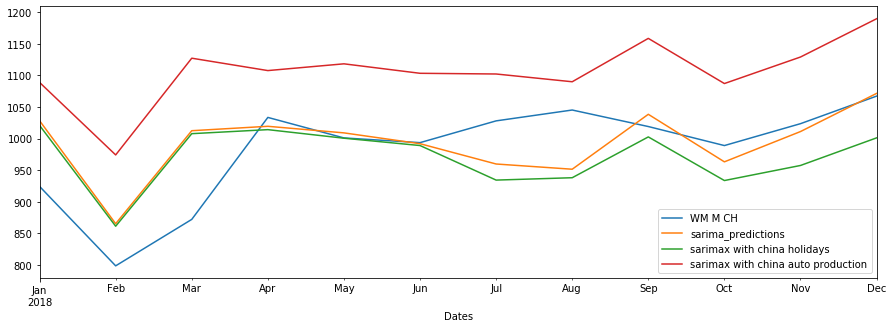

In [70]:
china_demand['WM M CH']['20180101':].plot(legend=True, figsize=(15,5))
sarima_ch_results['prediction'].plot(legend=True)
sarima_chhol_results['prediction'].rename('sarimax with china holidays').plot(legend=True)
sarima_auto_results['prediction'].rename('sarimax with china auto production').plot(legend=True)

The prediction including auto data was certainly higher than the rest and the China holidays alone weren't enough to improve the accuracy in Q1 using SARIMAX. This mightn't be a surprise for the start of the year, but there was notable weakness in 2H 2018 which doesn't appear to have been captured by the model.

#### XGBoost

We'll run the same with XGBoost to see if results improve there.

In [71]:
xgb_ch_ytrain = china_demand[['WM M CH']][:'20171231']
xgb_ch_ytest = china_demand[['WM M CH']]['20180101':]

In [72]:
xgb_ch_results = forecasts.xgb_fc(xgb_xtrain['20130101':], xgb_xtest, xgb_ch_ytrain, xgb_ch_ytest)
xgb_ch_results['rmse'], xgb_ch_results['rmse_pct']

[10:30:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(81.01413905667292, 0.08240821129779395)

In [73]:
xgb_ch_hols_train = xgb_xtrain.join(ch_hols_train).dropna()
xgb_ch_hols_test = xgb_xtest.join(ch_hols_test).dropna()

In [74]:
xgb_ch_hol_results = forecasts.xgb_fc(xgb_ch_hols_train, xgb_ch_hols_test, xgb_ch_ytrain, xgb_ch_ytest)
xgb_ch_hol_results['rmse'], xgb_ch_hol_results['rmse_pct']

[10:30:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(94.29965154757527, 0.09592233776137182)

In [75]:
xgb_ch_auto_train = xgb_xtrain.join(auto_train).dropna()
xgb_ch_auto_test = xgb_xtest.join(auto_test).dropna()

In [76]:
xgb_ch_auto_results = forecasts.xgb_fc(xgb_ch_auto_train, xgb_ch_auto_test, xgb_ch_ytrain, xgb_ch_ytest)
xgb_ch_auto_results['rmse'], xgb_ch_auto_results['rmse_pct']

[10:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(90.8564144913271, 0.09241985029210184)

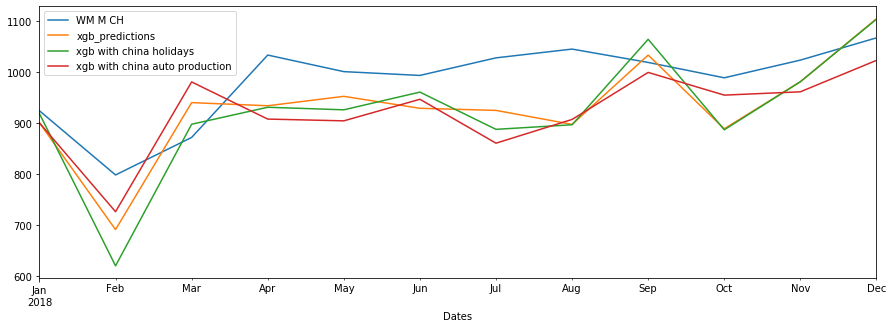

In [77]:
china_demand['WM M CH']['20180101':].plot(legend=True, figsize=(15,5))
xgb_ch_results['prediction'].plot(legend=True)
xgb_ch_hol_results['prediction'].rename('xgb with china holidays').plot(legend=True)
xgb_ch_auto_results['prediction'].rename('xgb with china auto production').plot(legend=True)

XGBoost also hasn't seen an improvement from the addition of either the Chinese holidays or auto production using a singular train/test split.

The takeaway is that perhaps these variables might not be the best options, at least for predicting 2018. There may be issues with direct causality within the specific month (copper for auto production may not be purchased in the same month as cars are produced etc). This may also be true of other variables so we might investigate using a short moving average or check if lagged data might work more effectively.

---

## Conclusion

We've only just scratched the surface of investigating the forecasting of copper demand. The myriad of potential forecasting methods, not to mention tuning parameters and creating/adding additional variables means there's plenty of avenues to explore and test.

Given the results we'd acheived thus far, we'd opt for a stacked SARIMA/XGBoost forecast for directly predicting global demand out of sample as the results were strong and the method kept additional unecessary calculations to a minimum.

That's not to say it wouldn't be prudent to delve further to improve forecasts.

### Further Analysis

- **Performance of forecast over time**
  
    The above calculations represent one train/test split instance and we are therefore testing only for the best performance in the training set. Effectively this training set changes with additional update, so performing a stepwise model at each update allows the tracking of forecast errors for different model (or parameter) choices at each stage. We can then apply a forecast model that has been the most consistent over time.
    
    
- **Additional models for testing**
  
    There are a huge number of potential models that might also be investigated. In terms of neural networks it may be that using an MLP model might perform better than an LSTM model in this instance for example. In terms of other alternatives there are of course other structures possible for both auto regresssion or decision trees, not to mention options such as Facebook's Prophet.
      
      
- **Source better historical data**
  
    In the analysis of country-specific demand we didn't have access to the history that would have been available with a subscription to the ICSG. There's no guarantee results would have improved, but a larger training set would have been preferable.
      
      
- **Other exogenous variables**

    As mentioned in this case, it would be interesting to produce a demand index from some of the main end use data to test. This could be weighted to the general contribution to copper demand and even adjusted/lagged to expected impact.
    
    One point not made previously is that whilst these variables might be updated before ICSG copper demand, they aren't likely to be updated to the end of the period we wish to forecast. If they improve forecasts in the training set therefore, there would have to be an additional forecast made on the results to extend out of sample.

Hopefully the above has given a good overview of some of the thought processes and decisions that need to be addressed when forecasting time series such as copper demand.

Any questions or comments, please feel free to get in touch directly.

Richard